## 信用卡欺詐檢測
基於信用卡交易記錄數據建立分類模型來預測哪些交易記錄是異常的哪些是正常的

### 請解壓縮data.rar，取得本程式之數據

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE , BorderlineSMOTE , ADASYN
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import trange

C:\Users\peng\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\peng\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\peng\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\peng\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (

數據讀取

In [2]:
data = pd.read_csv('creditcard.csv')
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


數據標簽分布很不平衡

In [3]:
count_classes = data['Class'].value_counts()
print('負樣本比例 : {:.2%}'.format(count_classes[0] / count_classes.sum()))
print('正樣本比例 : {:.2%}'.format(count_classes[1] / count_classes.sum()))

負樣本比例 : 99.83%
正樣本比例 : 0.17%


In [4]:
y = data['Class'] # label
X = data.drop(['Time' , 'Class'] , axis = 1) # feature

# 整個數據集進行劃分
x_train , x_test , y_train , y_test = train_test_split(X , y , test_size = 0.3 , random_state = 0)
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

對數據做normalization

In [5]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

怎麼對data進行採樣與組合，在Siamese Network中非常重要

In [6]:
def get_batch(data , label , batch_size = 500 , class_num = 2):

    # 收集500組data，每一組會有2筆data
    # 其中250組為similar_data_set，每一組data中包含2筆相同class的data
    # 另外250組data為dissimilar_data_set，每一組data中包含2筆不同class的data
    data_set , label_set = data , label

    similar_data_set = None
    similar_label_set = None
    for i in range(0 , class_num):
        # 從第i個class中的data中挑出250筆data成為data_set[index]
        # data_set[index] → [250 , 29]
        index = np.random.choice(np.where(label_set == i)[0] ,
                                 size = int(batch_size / class_num) ,
                                 replace = False)

        # 將data_set[index]中的data分為125組data，成為similar_data_pair
        # 每一組data中包含2筆相同class的data
        # similar_data_pair → [125 , 2 , 29]
        similar_data_pair = np.reshape(data_set[index] , [int(batch_size / 2 / class_num) , 2 , -1])
        if similar_data_set is None:
            similar_data_set = similar_data_pair
        else:
            # similar_data_set → [250 , 2 , 29] (執行迴圈2次，沿著axis 0，將similar_data_pair堆疊2次)
            similar_data_set = np.concatenate([similar_data_set , similar_data_pair] , axis = 0)

        # 決定每一組data所對應的label
        # similar_label_pair → [25 , 2 , 2]
        # label為0的similar_label_pair[: , : , 0] = 1
        # label1的similar_label_pair[: , : , 1] = 1
        similar_label_pair = np.zeros([int(batch_size / 2 / class_num) , 2 , class_num])
        similar_label_pair[: , : , i] = 1
        if similar_label_set is None:
            similar_label_set = similar_label_pair
        else:
            # similar_data_set → [250 , 2 , 2] (執行迴圈2次，沿著axis 0，將similar_data_pair堆疊2次)
            similar_label_set = np.concatenate([similar_label_set , similar_label_pair] , axis = 0)


    base_num = len(label)
    dissimilar_data_set = None
    dissimilar_label_set = None
    # 從0~base_num中隨機挑出250個不重複的數字成為index_a_set
    # index_a_set為dissimilar_data_set中每組data中第1筆data的index
    index_a_set = np.random.choice(range(0 , base_num) ,
                                   size = int(batch_size / 2) ,
                                   replace = False)
    for i in range(0 , int(batch_size / 2)):
        # label_a為dissimilar_data_set中每組data中第1筆data的label
        index_a = index_a_set[i]
        label_a = label_set[index_a]
        # label_b為dissimilar_data_set中每組data中第2筆data的label
        # 執行迴圈直到label_a不等於label_b為止
        while True:
            index_b = np.random.randint(0 , base_num)
            label_b = label_set[index_b]
            if label_b != label_a:
                break

        # data_set[index_a] → [29 , ] ⟹ data_a → [1 , 29]
        # data_set[index_b] → [29 , ] ⟹ data_b → [1 , 29]
        data_a = np.reshape(data_set[index_a] , [1 , -1])
        data_b = np.reshape(data_set[index_b] , [1 , -1])
        # dissimilar_data_pair → [2 , 29]
        dissimilar_data_pair = np.concatenate([data_a , data_b] , axis = 0)
        # dissimilar_data_pair → [1 , 2 , 29]
        dissimilar_data_pair = np.expand_dims(dissimilar_data_pair , axis = 0)
    
        if dissimilar_data_set is None:
            dissimilar_data_set = dissimilar_data_pair
        else:
           # dissimilar_data_set → [250 , 2 , 29] (執行迴圈250次，沿著axis 0，將dissimilar_data_pair堆疊250次)
           dissimilar_data_set = np.concatenate([dissimilar_data_set , dissimilar_data_pair] , axis = 0)

        # class_label_a → [1 , 2]
        # class_label_b → [1 , 2]
        class_label_a = np.zeros([1 , class_num])
        class_label_a[0 , label_a] = 1
        class_label_b = np.zeros([1 , class_num])
        class_label_b[0 , label_b] = 1
        # dissimilar_label_pair → [2 , 2]
        dissimilar_label_pair = np.concatenate([class_label_a , class_label_b] , axis = 0)
        # dissimilar_label_pair → [1 , 2 , 2]
        dissimilar_label_pair = np.expand_dims(dissimilar_label_pair , axis = 0)
        if dissimilar_label_set is None:
            dissimilar_label_set = dissimilar_label_pair
        else:
            # dissimilar_label_set → [250 , 2 , 2] (執行迴圈250次，沿著axis 0，將dissimilar_label_pair堆疊250次)
            dissimilar_label_set = np.concatenate([dissimilar_label_set , dissimilar_label_pair] , axis = 0)

    # data_set → [500 , 2 , 29]
    data_set = np.concatenate([similar_data_set , dissimilar_data_set] , axis = 0)
    # label_set → [500 , 2 , 2]
    label_set = np.concatenate([similar_label_set , dissimilar_label_set] , axis = 0)
    
    # 對data進行shuffle
    arr = np.arange(0 , batch_size)
    np.random.shuffle(arr)
    data_set = data_set[arr]
    label_set  = label_set[arr]

    return data_set , label_set

In [7]:
# hyperparameter
class_num = 2
n_input = x_train.shape[-1]
lr_siamese = 5e-4
lr_classifier_1 = 5e-4
lr_classifier_2 = 1e-4

In [8]:
input_tensor = tf.placeholder(tf.float32 , [None , 2 , n_input])
x_a = input_tensor[: , 0 , :]
x_b = input_tensor[: , 1 , :]
y_true = tf.placeholder(tf.float32 , [None , 2 , class_num])
y_true_a = y_true[: , 0 , :]
y_true_b = y_true[: , 1 , :]
keep_prob = tf.placeholder(tf.float32)

In [9]:
def add_layer(inputs , in_size , out_size , activaction_function = None , dropout = True):
    # initializer = tf.glorot_uniform_initializer()
    initializer = tf.contrib.layers.xavier_initializer()
    Weights = tf.get_variable(initializer = initializer([in_size , out_size]) , name = 'w_a')
    biases = tf.get_variable(initializer = tf.zeros([1 , out_size]) + 0.00001 , name = 'b_a')
    Wx_plus_b = tf.add(tf.matmul(inputs , Weights) , biases)
    if dropout:
        Wx_plus_b = tf.nn.dropout(Wx_plus_b , keep_prob)

    # here to activaction_function
    if activaction_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activaction_function(Wx_plus_b , name = 'output')
        
    return outputs

In [10]:
def feature_extractor(input_ , reuse = False):
    with tf.variable_scope('layer_1'):
        if reuse : tf.get_variable_scope().reuse_variables() 
        l1_f = add_layer(input_ , n_input , 50 , activaction_function = tf.nn.relu , dropout = True)

    with tf.variable_scope('layer_2'):
        if reuse : tf.get_variable_scope().reuse_variables() 
        l2_f = add_layer(l1_f , 50 , 30 , activaction_function = tf.nn.relu , dropout = True)

    with tf.variable_scope('layer_3'):
        if reuse : tf.get_variable_scope().reuse_variables()
        l3_f = add_layer(l2_f , 30 , 20 , activaction_function = tf.nn.relu , dropout = True)

    with tf.variable_scope('layer_4'):
        if reuse : tf.get_variable_scope().reuse_variables() 
        l4_f = add_layer(l3_f , 20 , 10 , activaction_function = tf.nn.relu , dropout = True)

    with tf.variable_scope('layer_5'):
        if reuse : tf.get_variable_scope().reuse_variables() 
        l5_f = add_layer(l4_f , 10 , 5 , activaction_function = tf.nn.relu , dropout = False)

    return l5_f

contrastive_loss的精華就在於希望同樣類別(相似)的data所產生的embedding vector越接近越好<br>
而不同類別(不相似)的data所產生的embedding vector越接近margin越好

In [11]:
with tf.variable_scope('siamese_network'):
    with tf.variable_scope('feature_extractor'):
        embedding_a = feature_extractor(x_a , reuse = False)
        embedding_b = feature_extractor(x_b , reuse = True)
    
    with tf.variable_scope('euclidean_distance'):
        distance = tf.reduce_sum(tf.pow(embedding_a - embedding_b , 2) , axis = 1)
        distance = tf.sqrt(tf.maximum(distance , 1e-9))
    
    # 仿造一般多分類cross entropy的寫法
    with tf.variable_scope('contrastive_loss'):
        margin = 1
        # decision_similarity其實就是y_true_a與y_true_b做內積的結果
        # 只要y_true_a的1與y_true_b的1出現在同一個位置，也就是x_a與x_b屬於同一個class，decision_similarity就是1
        # 只要y_true_a的1與y_true_b的1出現在不同的位置，也就是x_a與x_b屬於不同的class，decision_similarity就是0
        # ❶ y_true_a → [1 , 0]  &  y_true_b → [1 , 0] ⟹ decision_similarity = 1  ,  1 - decision_similarity = 0
        # ❶ y_true_a → [0 , 1]  &  y_true_b → [0 , 1] ⟹ decision_similarity = 1  ,  1 - decision_similarity = 0
        # ❶ contrastive_loss = similarity = tf.square(distance)
        # ❷ y_true_a → [1 , 0]  &  y_true_b → [0 , 1] ⟹ decision_similarity = 0  ,  1 - decision_similarity = 1
        # ❷ y_true_a → [0 , 1]  &  y_true_b → [0 , 1] ⟹ decision_similarity = 0  ,  1 - decision_similarity = 1
        # ❷ contrastive_loss = dissimilarity = tf.square(tf.maximum(margin - distance , 0))
        decision_similarity = tf.reduce_sum(tf.multiply(y_true_a , y_true_b) , axis = 1)
        similarity = tf.multiply(decision_similarity , tf.square(distance))
        dissimilarity = tf.multiply(1 - decision_similarity , tf.square(tf.maximum(margin - distance , 0)))
        contrastive_loss = tf.reduce_mean(similarity + dissimilarity)

    with tf.variable_scope('accuracy'):
        correct_siamese = tf.equal(tf.cast(tf.greater_equal(0.5 , distance) , tf.int32) , tf.cast(decision_similarity , tf.int32))
        accuracy_siamese = tf.reduce_mean(tf.cast(correct_siamese , tf.float32))

    with tf.variable_scope('optimizer'):
        variable_siamese  = []
        for i in tf.trainable_variables(): 
            if 'siamese_network' in i.name : variable_siamese.append(i)
        train_siamese = tf.train.AdamOptimizer(lr_siamese).minimize(contrastive_loss , var_list = variable_siamese)

可以利用'feature_extractor'所得到的embedding vector，輸入至此linear classifier來的到分類結果

In [12]:
with tf.variable_scope('classifier_network'):
    # 刻意只做了一個簡單的linear變換，為的就是要逼出'feature_extractor'的潛能，可以抽出良好的embedding vector
    # 如果可以非常好的代表label為0或label為1的data，即為良好的embedding vector
    with tf.variable_scope('layer_1'):
        l1_c = add_layer(embedding_a , 5 , 2 , activaction_function = None , dropout = False)
        
    # the error between prediction and real data
    with tf.variable_scope('cross_entropy'):
        prediction_a_ = tf.nn.softmax(l1_c , axis = 1)
        prediction_a_ = tf.clip_by_value(prediction_a_ , 1e-8 ,
                                          tf.reduce_max(prediction_a_))
        prediction_a = tf.log(prediction_a_)
        cross_entropy_temp = -tf.reduce_sum(y_true_a * prediction_a , axis = 1)
        cross_entropy = tf.reduce_mean(cross_entropy_temp)

    with tf.variable_scope('accuracy'):
        correct_classifier = tf.equal(tf.argmax(prediction_a , 1) , tf.argmax(y_true_a , 1))
        correct_classifier = tf.cast(correct_classifier , tf.float32)
        accuracy_classifier = tf.reduce_mean(correct_classifier)

    with tf.variable_scope('optimizer'):
        variable_classifier = []
        for i in tf.trainable_variables():
            if 'classifier_network' in i.name : variable_classifier.append(i)    
        train_classifier_1 = tf.train.AdamOptimizer(lr_classifier_1).minimize(cross_entropy , var_list = variable_classifier)
        train_classifier_2 = tf.train.AdamOptimizer(lr_classifier_2).minimize(cross_entropy , var_list = variable_siamese)
        train_classifier = tf.group([train_classifier_1 , train_classifier_2])

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

val_loss_siamese_record = []
for batch_i in range(0 , 5000):
    # 每經過5個batch，就會利用oversampler合成不同的"標籤為0"的data(較少數的data)
    # 以防止network看過太多同樣的data，進而產生overfitting的現象
    if batch_i % 5 == 0:
        decision_oversampler = np.random.randint(0 , 4)
        if decision_oversampler == 0:
            oversampler = SMOTE(n_jobs = -1)
        elif decision_oversampler == 1:
            oversampler = BorderlineSMOTE(kind = 'borderline-1' , n_jobs = -1)
        elif decision_oversampler == 2:
            oversampler = BorderlineSMOTE(kind = 'borderline-2' , n_jobs = -1)
        elif decision_oversampler == 3:
            oversampler = ADASYN(n_jobs = -1)
        x_train_oversample , y_train_oversample = oversampler.fit_sample(x_train , y_train)

    x_batch , y_batch = get_batch(x_train_oversample , y_train_oversample)

    sess.run([train_siamese , train_classifier] , feed_dict = {input_tensor : x_batch  ,
                                                               y_true : y_batch ,
                                                               keep_prob : 0.8})

    if batch_i % 10 == 0:
        train_loss_siamese , train_accuracy_siamese , train_loss_classifier , train_accuracy_classifier =\
        sess.run([contrastive_loss , accuracy_siamese , cross_entropy , accuracy_classifier] , feed_dict = {input_tensor : x_batch ,
                                                                                                            y_true : y_batch ,
                                                                                                            keep_prob : 1})

        print('=' * 30)
        print('batch_i : {}'.format(batch_i))
        print('training_loss_siamese : {:.4f}'.format(train_loss_siamese))
        print('training_accuracy_siamese : {:.2%}'.format(train_accuracy_siamese))
        print('training_loss_classifier : {:.4f}'.format(train_loss_classifier))
        print('training_accuracy_classifier : {:.2%}\n'.format(train_accuracy_classifier))

        x_val , y_val  = get_batch(x_test , y_test , batch_size = 200)

        val_loss_siamese , val_accuracy_siamese = sess.run([contrastive_loss , accuracy_siamese] , feed_dict = {input_tensor : x_val ,
                                                                                                                y_true : y_val ,
                                                                                                                keep_prob : 1})
    
        print('*' * 30)
        print('batch_i : {}'.format(batch_i))
        print('validation_loss_siamese : {:.4f}'.format(val_loss_siamese))
        print('validation_accuracy_siamese : {:.2%}'.format(val_accuracy_siamese))
        print('*' * 30 , '\n')

        val_loss_siamese_record.append(val_loss_siamese)

batch_i : 0
training_loss_siamese : 0.3469
training_accuracy_siamese : 53.40%
training_loss_classifier : 0.6912
training_accuracy_classifier : 55.40%

******************************
batch_i : 0
validation_loss_siamese : 0.5613
validation_accuracy_siamese : 51.50%
****************************** 

batch_i : 10
training_loss_siamese : 0.3909
training_accuracy_siamese : 50.20%
training_loss_classifier : 0.6847
training_accuracy_classifier : 58.80%

******************************
batch_i : 10
validation_loss_siamese : 0.4039
validation_accuracy_siamese : 48.50%
****************************** 

batch_i : 20
training_loss_siamese : 0.3835
training_accuracy_siamese : 52.40%
training_loss_classifier : 0.6813
training_accuracy_classifier : 61.60%

******************************
batch_i : 20
validation_loss_siamese : 0.4178
validation_accuracy_siamese : 51.00%
****************************** 

batch_i : 30
training_loss_siamese : 0.4074
training_accuracy_siamese : 50.60%
training_loss_classifier :

training_loss_classifier : 0.4676
training_accuracy_classifier : 85.60%

******************************
batch_i : 490
validation_loss_siamese : 0.1216
validation_accuracy_siamese : 84.50%
****************************** 

batch_i : 500
training_loss_siamese : 0.1312
training_accuracy_siamese : 81.40%
training_loss_classifier : 0.4441
training_accuracy_classifier : 87.40%

******************************
batch_i : 500
validation_loss_siamese : 0.0892
validation_accuracy_siamese : 90.00%
****************************** 

batch_i : 510
training_loss_siamese : 0.0631
training_accuracy_siamese : 94.20%
training_loss_classifier : 0.3710
training_accuracy_classifier : 98.20%

******************************
batch_i : 510
validation_loss_siamese : 0.1126
validation_accuracy_siamese : 87.00%
****************************** 

batch_i : 520
training_loss_siamese : 0.0780
training_accuracy_siamese : 91.40%
training_loss_classifier : 0.3846
training_accuracy_classifier : 95.20%

************************

batch_i : 980
validation_loss_siamese : 0.1075
validation_accuracy_siamese : 85.50%
****************************** 

batch_i : 990
training_loss_siamese : 0.0335
training_accuracy_siamese : 96.00%
training_loss_classifier : 0.2466
training_accuracy_classifier : 98.00%

******************************
batch_i : 990
validation_loss_siamese : 0.1167
validation_accuracy_siamese : 84.00%
****************************** 

batch_i : 1000
training_loss_siamese : 0.0884
training_accuracy_siamese : 88.40%
training_loss_classifier : 0.3163
training_accuracy_classifier : 92.40%

******************************
batch_i : 1000
validation_loss_siamese : 0.0814
validation_accuracy_siamese : 89.00%
****************************** 

batch_i : 1010
training_loss_siamese : 0.0656
training_accuracy_siamese : 91.40%
training_loss_classifier : 0.2824
training_accuracy_classifier : 95.00%

******************************
batch_i : 1010
validation_loss_siamese : 0.0712
validation_accuracy_siamese : 90.50%
*********

batch_i : 1470
validation_loss_siamese : 0.0824
validation_accuracy_siamese : 88.50%
****************************** 

batch_i : 1480
training_loss_siamese : 0.0211
training_accuracy_siamese : 97.00%
training_loss_classifier : 0.1684
training_accuracy_classifier : 98.80%

******************************
batch_i : 1480
validation_loss_siamese : 0.1058
validation_accuracy_siamese : 87.50%
****************************** 

batch_i : 1490
training_loss_siamese : 0.0296
training_accuracy_siamese : 96.40%
training_loss_classifier : 0.1762
training_accuracy_classifier : 98.20%

******************************
batch_i : 1490
validation_loss_siamese : 0.0891
validation_accuracy_siamese : 90.00%
****************************** 

batch_i : 1500
training_loss_siamese : 0.0110
training_accuracy_siamese : 99.00%
training_loss_classifier : 0.1619
training_accuracy_classifier : 99.20%

******************************
batch_i : 1500
validation_loss_siamese : 0.1007
validation_accuracy_siamese : 88.00%
******

batch_i : 1960
validation_loss_siamese : 0.1304
validation_accuracy_siamese : 85.00%
****************************** 

batch_i : 1970
training_loss_siamese : 0.0128
training_accuracy_siamese : 98.60%
training_loss_classifier : 0.1178
training_accuracy_classifier : 99.40%

******************************
batch_i : 1970
validation_loss_siamese : 0.0719
validation_accuracy_siamese : 90.50%
****************************** 

batch_i : 1980
training_loss_siamese : 0.0051
training_accuracy_siamese : 99.40%
training_loss_classifier : 0.1046
training_accuracy_classifier : 100.00%

******************************
batch_i : 1980
validation_loss_siamese : 0.0968
validation_accuracy_siamese : 89.50%
****************************** 

batch_i : 1990
training_loss_siamese : 0.0041
training_accuracy_siamese : 99.40%
training_loss_classifier : 0.1057
training_accuracy_classifier : 99.80%

******************************
batch_i : 1990
validation_loss_siamese : 0.0747
validation_accuracy_siamese : 92.50%
*****

batch_i : 2450
validation_loss_siamese : 0.0989
validation_accuracy_siamese : 90.00%
****************************** 

batch_i : 2460
training_loss_siamese : 0.0026
training_accuracy_siamese : 99.60%
training_loss_classifier : 0.0805
training_accuracy_classifier : 99.80%

******************************
batch_i : 2460
validation_loss_siamese : 0.1034
validation_accuracy_siamese : 88.50%
****************************** 

batch_i : 2470
training_loss_siamese : 0.0066
training_accuracy_siamese : 99.40%
training_loss_classifier : 0.0785
training_accuracy_classifier : 100.00%

******************************
batch_i : 2470
validation_loss_siamese : 0.1044
validation_accuracy_siamese : 89.00%
****************************** 

batch_i : 2480
training_loss_siamese : 0.0019
training_accuracy_siamese : 99.80%
training_loss_classifier : 0.0812
training_accuracy_classifier : 99.60%

******************************
batch_i : 2480
validation_loss_siamese : 0.1065
validation_accuracy_siamese : 88.50%
*****

******************************
batch_i : 2940
validation_loss_siamese : 0.1181
validation_accuracy_siamese : 88.00%
****************************** 

batch_i : 2950
training_loss_siamese : 0.0025
training_accuracy_siamese : 99.60%
training_loss_classifier : 0.0649
training_accuracy_classifier : 99.60%

******************************
batch_i : 2950
validation_loss_siamese : 0.1086
validation_accuracy_siamese : 89.00%
****************************** 

batch_i : 2960
training_loss_siamese : 0.0031
training_accuracy_siamese : 99.80%
training_loss_classifier : 0.0653
training_accuracy_classifier : 99.80%

******************************
batch_i : 2960
validation_loss_siamese : 0.1396
validation_accuracy_siamese : 85.50%
****************************** 

batch_i : 2970
training_loss_siamese : 0.0020
training_accuracy_siamese : 99.80%
training_loss_classifier : 0.0627
training_accuracy_classifier : 99.80%

******************************
batch_i : 2970
validation_loss_siamese : 0.0999
validation_a


******************************
batch_i : 3430
validation_loss_siamese : 0.1338
validation_accuracy_siamese : 86.50%
****************************** 

batch_i : 3440
training_loss_siamese : 0.0026
training_accuracy_siamese : 99.80%
training_loss_classifier : 0.0520
training_accuracy_classifier : 99.80%

******************************
batch_i : 3440
validation_loss_siamese : 0.1338
validation_accuracy_siamese : 86.50%
****************************** 

batch_i : 3450
training_loss_siamese : 0.0004
training_accuracy_siamese : 100.00%
training_loss_classifier : 0.0457
training_accuracy_classifier : 100.00%

******************************
batch_i : 3450
validation_loss_siamese : 0.1243
validation_accuracy_siamese : 87.50%
****************************** 

batch_i : 3460
training_loss_siamese : 0.0016
training_accuracy_siamese : 99.80%
training_loss_classifier : 0.0506
training_accuracy_classifier : 99.80%

******************************
batch_i : 3460
validation_loss_siamese : 0.1632
validatio


******************************
batch_i : 3920
validation_loss_siamese : 0.1770
validation_accuracy_siamese : 82.00%
****************************** 

batch_i : 3930
training_loss_siamese : 0.0000
training_accuracy_siamese : 100.00%
training_loss_classifier : 0.0363
training_accuracy_classifier : 100.00%

******************************
batch_i : 3930
validation_loss_siamese : 0.1655
validation_accuracy_siamese : 83.50%
****************************** 

batch_i : 3940
training_loss_siamese : 0.0000
training_accuracy_siamese : 100.00%
training_loss_classifier : 0.0361
training_accuracy_classifier : 100.00%

******************************
batch_i : 3940
validation_loss_siamese : 0.1375
validation_accuracy_siamese : 86.00%
****************************** 

batch_i : 3950
training_loss_siamese : 0.0001
training_accuracy_siamese : 100.00%
training_loss_classifier : 0.0369
training_accuracy_classifier : 100.00%

******************************
batch_i : 3950
validation_loss_siamese : 0.1427
valid


******************************
batch_i : 4410
validation_loss_siamese : 0.0936
validation_accuracy_siamese : 90.50%
****************************** 

batch_i : 4420
training_loss_siamese : 0.0048
training_accuracy_siamese : 99.60%
training_loss_classifier : 0.0291
training_accuracy_classifier : 100.00%

******************************
batch_i : 4420
validation_loss_siamese : 0.1565
validation_accuracy_siamese : 84.00%
****************************** 

batch_i : 4430
training_loss_siamese : 0.0084
training_accuracy_siamese : 99.00%
training_loss_classifier : 0.0414
training_accuracy_classifier : 99.40%

******************************
batch_i : 4430
validation_loss_siamese : 0.1135
validation_accuracy_siamese : 88.50%
****************************** 

batch_i : 4440
training_loss_siamese : 0.0020
training_accuracy_siamese : 99.80%
training_loss_classifier : 0.0355
training_accuracy_classifier : 99.80%

******************************
batch_i : 4440
validation_loss_siamese : 0.1656
validation


******************************
batch_i : 4900
validation_loss_siamese : 0.1713
validation_accuracy_siamese : 82.50%
****************************** 

batch_i : 4910
training_loss_siamese : 0.0000
training_accuracy_siamese : 100.00%
training_loss_classifier : 0.0230
training_accuracy_classifier : 100.00%

******************************
batch_i : 4910
validation_loss_siamese : 0.1375
validation_accuracy_siamese : 86.50%
****************************** 

batch_i : 4920
training_loss_siamese : 0.0063
training_accuracy_siamese : 99.20%
training_loss_classifier : 0.0347
training_accuracy_classifier : 99.60%

******************************
batch_i : 4920
validation_loss_siamese : 0.1256
validation_accuracy_siamese : 87.50%
****************************** 

batch_i : 4930
training_loss_siamese : 0.0003
training_accuracy_siamese : 100.00%
training_loss_classifier : 0.0239
training_accuracy_classifier : 100.00%

******************************
batch_i : 4930
validation_loss_siamese : 0.1649
validat

In [14]:
def plot_confusion_matrix(cm , classes ,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                  color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    return plt

Recall : 0.844
Precision : 0.420


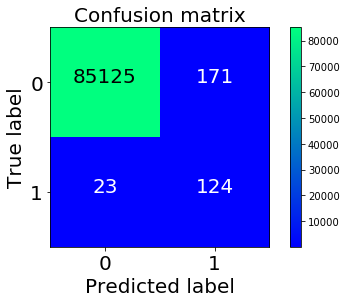

In [15]:
# inference_方法1
y_pred_1 = sess.run(tf.argmax(prediction_a_ , axis = 1) ,
                    feed_dict = {x_a : x_test , keep_prob : 1})

cm = confusion_matrix(y_test , y_pred_1)
plot_confusion_matrix(cm , classes = [0 , 1] , normalize = False , title = 'Confusion matrix')
recall = cm[1 , 1] / (cm[1 , 0] + cm[1 , 1])
precision = cm[1 , 1] / (cm[0 , 1] + cm[1 , 1])
print('Recall : {:.3f}'.format(recall))
print('Precision : {:.3f}'.format(precision))

相對於 "11_信用卡詐欺檢測_不均衡數據_undersample_oversample(SMOTE)"<br>
可以發現雖然犧牲了一點recall，但卻大幅度減少原本label為0，但被預測為1的情況<br>
也就是大幅度提升模型預測data在"label為0"的能力，也可以說是大幅提升precision，但神奇的是卻只有稍微削減模型預測data在"label為1"的能力

100%|████████████████████████████████████████████████████████████████████████████| 85443/85443 [27:45<00:00, 51.31it/s]


Recall : 0.857
Precision : 0.339


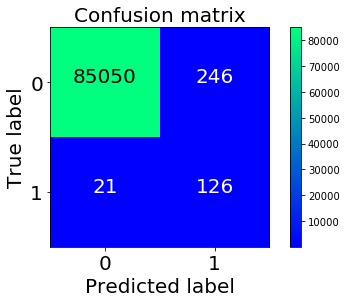

In [16]:
# inference_方法2(比較費時)
# 隨機從label為0的x_train中抽出100筆data，再計算每筆x_test與抽出100筆data的距離
# 若距離小於threshold，count_normal就加1
# 若距離大於threshold，count_anomaly就加1
# 如果count_normal大於count_anomaly，就將該筆x_test判定為0
# 如果count_anomaly大於count_normal，就將該筆x_test判定為1
threshold = 0.1
x_train_normal = x_train[y_train == 0]
y_pred_2 = np.zeros([85443 , ])
for i in trange(0 , 85443):
    count_normal = 0
    count_anomaly = 0
    normal_index = np.random.choice(len(x_train_normal) ,
                                    size = 1000 ,
                                    replace = False)
    
    x_normal_sample = x_train_normal[normal_index , :]
    x_test_copy = [x_test[i , :] for _ in range(0 , 1000)]    
    x_test_copy = np.array(x_test_copy)
    
    distance_ = sess.run(distance  ,
                         feed_dict = {x_a : x_normal_sample ,
                                      x_b : x_test_copy ,
                                      keep_prob : 1})
    
    count_normal = (distance_ < threshold).sum()
    count_anomaly = (distance_ >= threshold).sum()
    if count_normal > count_anomaly:
        y_pred_2[i] = 0
    elif count_normal < count_anomaly:
        y_pred_2[i] = 1
    
cm = confusion_matrix(y_test , y_pred_2)
plot_confusion_matrix(cm , classes = [0 , 1] , normalize = False , title = 'Confusion matrix')
recall = cm[1 , 1] / (cm[1 , 0] + cm[1 , 1])
precision = cm[1 , 1] / (cm[0 , 1] + cm[1 , 1])
print('Recall : {:.3f}'.format(recall))
print('Precision : {:.3f}'.format(precision))